Due to the chosen bluffness ratio, the nose cone length was reduced to 0.12776789030970567 m.


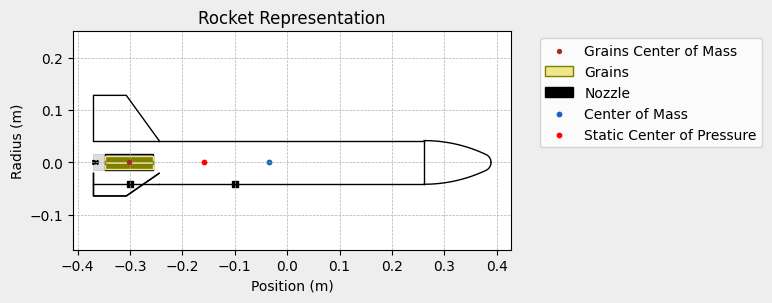


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 4.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.924 | e1: -0.008 | e2: 0.003 | e3: 0.383
Euler Angles - Spin φ : 45.00° | Nutation θ: -1.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 1.490 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 1.5 m
Launch Rail Inclination: 89.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.407 s
Rail Departure Velocity: 6.654 m/s
Rail Departure Stability Margin: 1.507 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 2.889
Rail Departure Reynolds Number: 3.794e+04


Burn out State

Burn out time: 5.300 s
Altitude at burn out: 133.372 m (ASL) | 129.372 m (AGL)
Rocket speed at burn out: 17.028 m/s
Freestream velocity at 

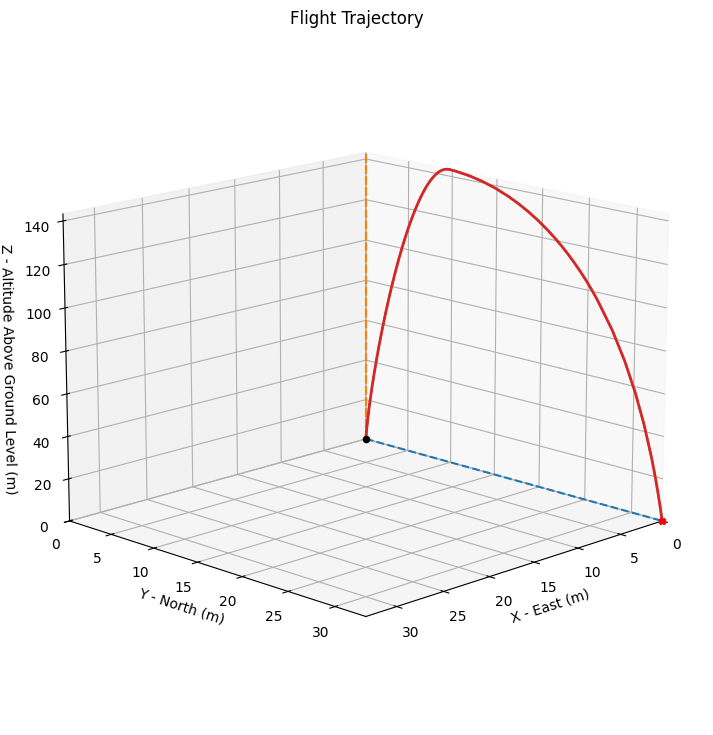

In [29]:
# Libraries
from rocketpy import Environment, SolidMotor, Rocket, Flight
import math

# Construct Launch Site Environment
launch_site = Environment(
    latitude=(27 + (55/60) + (58/3600)), # [deg] positive corresponds to North
    longitude=-(80 + (42/60) + (30/3600)), # [deg] positive corresponds to East
    elevation=4 # [m] launch site elevation above sea level
)

# AeroTech-G25W Motor Characteristics
propellant_length=0.09235 # [m] length of propellant grain
propellant_OD=0.02355 # [m] outer diameter of propellant grain
propellant_ID=0.00608 # [m] diameter of propellant core
propellant_mass=62.5/1000 # [kg] mass of propellant

nozzle_length=0.0224 # [m] nozzle length (measured from exit plane to plane abutting propellant grain)

CG_position_dry=0.07309 # [m] positiion of motor CG without propellant (relative to nozzle exit plane)

# Construct AeroTechG25W Solid Rocket Motor
AeroTechG25W = SolidMotor(
    thrust_source="AeroTechG25W_thrustcurve.csv", # [s, N]
    dry_mass=101.72/1000, # [kg]
    dry_inertia=(235307.21*(1000**(-3)), 235307.21*(1000**(-3)), 13414.14*(1000**(-3))), # [kg*m^2] motor's dry mass inertia tensor components (e_3 = rocket symmetry axis)
    nozzle_radius=7.70/2/1000, # [m] nozzle exit radius
    grain_number=1, # [unitless]
    grain_density=propellant_mass/(propellant_length*(math.pi*(propellant_OD/2)**2 - math.pi*(propellant_ID/2)**2)), # [kg/m^2]
    grain_outer_radius=propellant_OD/2, # [m]
    grain_initial_inner_radius=propellant_ID/2, # [m]
    grain_initial_height=propellant_length, # [m]
    grain_separation=0, # [m] all one propellant grain
    grains_center_of_mass_position=nozzle_length + (propellant_length/2), # [m]
    center_of_dry_mass_position=CG_position_dry, # [m]
    nozzle_position=0.0, # [m] position of nozzle exit area, relative to motor coordinate system origin
    burn_time=None, # [s] derived from `thrust_source`
    throat_radius=3.56/2/1000, # [m] radius of nozzle throat
    reshape_thrust_curve=False,
    interpolation_method="linear",
    coordinate_system_orientation="nozzle_to_combustion_chamber" # direction of positive coordinate system axis
)

# Rocket Characteristics
total_mass = 1434.96/1000 # [kg] maximum allowable rocket mass per 14 CFR Part 101.22
motor_mass = AeroTechG25W.propellant_initial_mass + AeroTechG25W.dry_mass # [kg] total mass of ONE motor

# Construct Rocket
DART_rocket = Rocket(
    radius=(3.28/2*25.4)/1000, # [m] largest outer radius
    mass=total_mass - motor_mass, # [kg] dry mass of the rocket
    inertia=(46065894.35*(1000**(-3)), 46057059.28*(1000**(-3)), 1796848.98*(1000**(-3)), 4106.46*(1000**(-3)), 53311.54*(1000**(-3)), 60557.58*(1000**(-3))), # [kg*m^2] rocket inertia tensor components (e_3 = rocket symmetry axis)
    power_off_drag=1.6939, # [unitless] C_D without motor firing
    power_on_drag=1.6939, # [unitless] C_D with motor firing
    center_of_mass_without_motor=0, # [m] position of the rocket CG w/o motors relative to the rocket's coordinate system
    coordinate_system_orientation="tail_to_nose" # direction of positive coordinate system axis
)

'''
-------------------- Add Ascent Motor --------------------
postion: [m] Position of the motor's coordinate system origin relative to the user defined rocket coordinate system
'''
DART_rocket.add_motor(AeroTechG25W, position=-0.370869)

'''
-------------------- Add Rail Buttons --------------------
upper_button_position: Position of the rail button furthest from the nozzle relative to the rocket's coordinate system
lower_button_position: Position of the rail button closest to the nozzle relative to the rocket's coordinate system
'''
DART_rocket.set_rail_buttons(upper_button_position=-0.1, lower_button_position=-0.3) # [ARBITRARILY CHOSEN AND NEEDS TO BE UPDATED] !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

'''
-------------------- Add Nose Cone --------------------
length: [m] length of the nose cone (excluding the shoulder)
kind: One of {Von Karman, conical, ogive, lvhaack, powerseries}
position: [m] Nose cone tip coordinate relative to the rocket's coordinate system
'''
DART_rocket.add_nose(length=0.145836, kind="ogive", position=0.389190, bluffness=0.6/1.5)

# Construct Fins
DART_fins = DART_rocket.add_trapezoidal_fins(
    n=3, # [unitless] number of fins
    root_chord=0.125223, # [m]
    tip_chord=0.062611, # [m]
    span=0.08636, # [m]
    position=-0.244369, # [m]
    cant_angle=0, # [deg] cant (i.e., tilt) angle of fins (non-zero will induce roll)
    airfoil=("NACA0012.csv", "degrees"), # [CSV of {alpha,C_L}, alpha provided in degrees]
)

# Parachute Characteristics
C_D = 0.84 # [unitless] parachute drag coefficient
parachute_reference_area=math.pi*(30*0.0254/2)**2 # [m^2] reference area of parachute

# Construct Parachute
main = DART_rocket.add_parachute(
    name="main", # name of the parachute (no impact on simulation)
    cd_s=C_D*parachute_reference_area, # [m^2] drag coefficient times parachute reference area
    trigger="apogee", # will trigger the parachute deployment at apogee (can also use a callable function based on fresstream pressure, altitude, and state vector)
    sampling_rate=10, # [Hz] sampling rate in which the trigger function works (used to simulate sensor refresh rates)
    lag=0, # [s] time between the ejection system is triggers and the parachute is fully opened (SHOULD BE QUANTIFIED WITH EJECTION TESTING)
    noise=(0,0,0) # [Pa] (mean, standard deviation, time-correlation) used to add noise to the pressure signal
)

test_flight = Flight(
    rocket=DART_rocket,
    environment=launch_site,
    rail_length=1.5, # [m] length of the launch rail (NEED TO DOUBLE CHECK UNITS)
    inclination=89, # [deg] rail inclination relative to the ground
    heading=0, # [deg] heading angle relative to North (East = 90)
    time_overshoot=True # decouples ODE time step from parachute trigger functions sampling rate
)

DART_rocket.draw()
test_flight.prints.all()
test_flight.plots.trajectory_3d()